In [6]:
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [8]:
diabetes=pd.read_csv('diabetes.csv')
diabetes.head()
#diabetes.Outcome.value_counts(dropna=False)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Assumptions of Logistic Reg

## No colinearity

In [9]:
# X/y split
X = diabetes.drop('Outcome',axis = 1)
y = diabetes['Outcome']

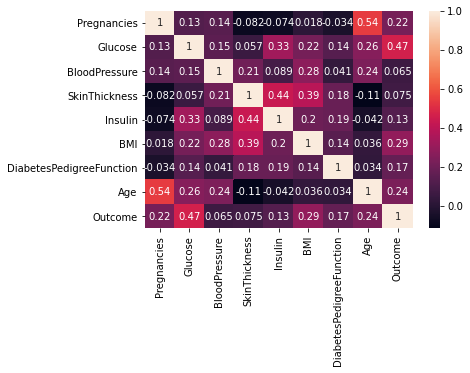

In [10]:
correlations_matrix = diabetes.corr()                   #diabetes.corr for numeric otherwise X.corr
sns.heatmap(correlations_matrix, annot=True)
plt.show()

## Standardization of independent variables

In [11]:
# here we start scaling, so need to do train-test-split before
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default fraction is .2

In [12]:
# all features are numeric, so no need to split into _num and _cat
transformer = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(transformer.transform(X_train),columns=X.columns)
# because this is the only tranformation we apply to the numerics, 
# we can immediately transform the X_test as well
X_test_scaled = pd.DataFrame(transformer.transform(X_test),columns=X.columns)
X_train_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.507552,-1.015215,-0.404519,-1.319215,-0.718238,-1.220701,-0.983259,-0.048640
1,-0.829864,-0.099647,-0.615096,0.928730,0.083747,0.137191,-0.624936,-0.882466
2,-1.122041,-0.952072,0.543076,-1.319215,-0.718238,0.024033,0.398842,-0.548935
3,2.384083,0.594922,0.648364,1.365830,2.054583,0.879002,0.179030,2.035925
4,1.507552,0.752778,0.543076,1.553159,0.390891,0.715552,0.507242,0.535038


In [13]:
y_train = y_train.reset_index(drop=True) 
# needed because the transformation also reset the index for X_train_scaled
# so we need this for y_test as well...
y_test = y_test.reset_index(drop=True) 



## Linear relation on logit - what?

In [14]:
# remember linear regression? We expected the relation between x and y to actually be linear!
# should we expect the same from logistic regression?

In [15]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_scaled, y_train)

LogisticRegression(random_state=0)

In [16]:
logits = np.log(1/LR.predict_proba(X_train_scaled)[:,1]-1)

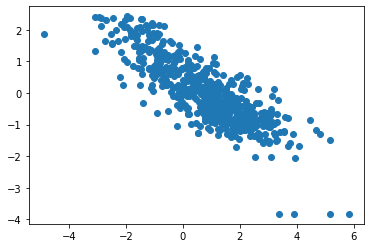

In [17]:
plt.scatter(logits,X_train_scaled['Glucose'])

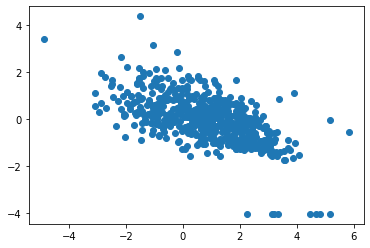

In [18]:
plt.scatter(logits,X_train_scaled['BMI'])

# Imbalance and metrics

<AxesSubplot:>

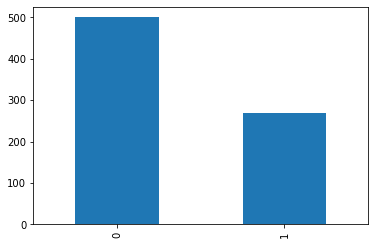

In [19]:
# while there are more imbalanced datasets, we have a significant imbalance
# and the cost of failing to detect the minority class is quite high (lack of diagnosis of diabetes)
count_classes = diabetes['Outcome'].value_counts()
count_classes.plot(kind = 'bar')

# A relatively bad model

In [20]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_scaled, y_train)
LR.score(X_test_scaled, y_test)

0.8020833333333334

In [21]:
# What does this number mean??
# Discuss precision and recall

In [22]:
#while accuracy is not absolutely terrible, a closer look reveals some serious problems
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))


precision:  0.75
recall:  0.5806451612903226
f1:  0.6545454545454547


In [23]:
#we fail to identify 40%+ of diabetes cases!
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)

array([[118,  12],
       [ 26,  36]], dtype=int64)

# Oversampling / undersampling

In [24]:
from sklearn.utils import resample

In [25]:
# oversampling / undersampling is only to be done on the TRAINING set
# our test set still must reflect reality!
train = pd.concat([X_train_scaled, y_train],axis=1)
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.507552,-1.015215,-0.404519,-1.319215,-0.718238,-1.220701,-0.983259,-0.048640,0
1,-0.829864,-0.099647,-0.615096,0.928730,0.083747,0.137191,-0.624936,-0.882466,0
2,-1.122041,-0.952072,0.543076,-1.319215,-0.718238,0.024033,0.398842,-0.548935,0
3,2.384083,0.594922,0.648364,1.365830,2.054583,0.879002,0.179030,2.035925,1
4,1.507552,0.752778,0.543076,1.553159,0.390891,0.715552,0.507242,0.535038,1


## Oversampling

In [26]:
# separate majority/minority classes
no_diabetes = train[train['Outcome']==0]
yes_diabetes = train[train['Outcome']==1]

In [27]:
display(no_diabetes.shape)
display(yes_diabetes.shape)

(370, 9)

(206, 9)

In [28]:
# oversample minority
yes_diabetes_oversampled = resample(yes_diabetes, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_diabetes),#<- make both sets the same size
                                    random_state=0)

In [29]:
# both sets are now of a reasonable size
display(no_diabetes.shape)
display(yes_diabetes_oversampled.shape)

(370, 9)

(370, 9)

In [30]:
train_oversampled = pd.concat([no_diabetes,yes_diabetes_oversampled],axis=0)
train_oversampled.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
531,0.631021,2.331343,0.016634,-1.319215,-0.718238,-0.164563,-0.423192,-0.215405,1
546,-1.122041,-0.541645,-0.299231,0.991173,-0.172205,0.174910,0.124830,-0.965849,1
152,-0.829864,0.721207,0.648364,1.553159,0.817478,1.746544,-0.402114,1.035334,1
369,-0.829864,-0.825787,0.648364,0.241858,0.817478,0.350933,-0.709248,0.785186,1
505,-0.245510,1.668346,-0.615096,0.054529,0.936923,0.086898,0.374753,0.201508,1


In [31]:
y_train_over = train_oversampled['Outcome'].copy()
X_train_over = train_oversampled.drop('Outcome',axis = 1).copy()

In [32]:
# Our Logistic Regression, while still not amazing, has improved substantially!
# especially at detecting instances of diabetes
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_over, y_train_over)
pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.6388888888888888
recall:  0.7419354838709677
f1:  0.6865671641791045


In [33]:
confusion_matrix(y_test,pred)

array([[104,  26],
       [ 16,  46]], dtype=int64)

## Undersampling

In [34]:
# undersample majority
no_diabetes_undersampled = resample(no_diabetes, #<- downsample from here
                                    replace=False, #<- no need to reuse data now, we have an abundance
                                    n_samples = len(yes_diabetes),
                                    random_state=0)

In [35]:
# both sets are the same size
# small, but balanced, and no repeated data
display(yes_diabetes.shape)
display(no_diabetes_undersampled.shape)

(206, 9)

(206, 9)

In [36]:
train_undersampled = pd.concat([yes_diabetes,no_diabetes_undersampled])
train_undersampled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,2.384083,0.594922,0.648364,1.365830,2.054583,0.879002,0.179030,2.035925,1
4,1.507552,0.752778,0.543076,1.553159,0.390891,0.715552,0.507242,0.535038,1
12,-0.829864,-0.257503,-0.299231,0.866287,-0.718238,0.174910,0.224197,-1.049231,1
16,-0.537687,1.068491,0.227211,-0.257685,0.100811,-0.705205,-0.107025,-0.548935,1
18,-1.122041,-0.825787,0.806297,0.241858,-0.411094,0.652686,-0.667092,-0.799083,1


In [37]:
y_train_under = train_undersampled['Outcome'].copy()
X_train_under = train_undersampled.drop('Outcome',axis = 1).copy()

In [38]:
# Still a slight improvement!
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_under, y_train_under)
pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.6438356164383562
recall:  0.7580645161290323
f1:  0.6962962962962962


In [39]:
confusion_matrix(y_test,pred)

array([[104,  26],
       [ 15,  47]], dtype=int64)

# SMOTE

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
# a bit of magic, you can find documentation here: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
# by deafult, takes a 5-neighbour KNN to build a new point, experimenting led us to choose 3 here
sm = SMOTE(random_state=100,k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_scaled,y_train)

In [42]:
X_train_SMOTE.shape

(740, 8)

In [43]:
# yet another small improvement, but bear in mind that we saved 12 hypothetical people with
# these "small improvements"
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_SMOTE, y_train_SMOTE)
pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.6486486486486487
recall:  0.7741935483870968
f1:  0.7058823529411764


In [44]:
confusion_matrix(y_test,pred)

array([[104,  26],
       [ 14,  48]], dtype=int64)